# Temat testów:

### Czy istnieje istotna statystycznie różnica w poprawności odpowiedzi w zależności od czasu odpowiedzi? (grupy: wszystkie grafiki, grafiki A, grafiki B, grafiki 1,2,3)

In [69]:
import statsmodels.api as sm
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_corr = pd.read_csv('/Users/martasolarz/Studies/Thesis/data/correctness.csv',
    usecols=['ID', '1a_corr', '1b_corr', '2a_corr', '2b_corr', '3a_corr', '3b_corr']
)

df_corr = df_corr[df_corr.ID != 6] # odrzucony uczestnik ze względu na metryki eye trackingowe

df_time =  pd.read_csv('/Users/martasolarz/Studies/Thesis/data/metrics/times.csv',
    usecols=['ID', 'Duration_1a', 'Duration_1b', 'Duration_2a', 'Duration_2b', 'Duration_3a', 'Duration_3b']
)

df_merge = df_corr.merge(df_time, on='ID')
df_merge.head()

,ID,1a_corr,1b_corr,2a_corr,2b_corr,3a_corr,3b_corr,Duration_1a,Duration_1b,Duration_2a,Duration_2b,Duration_3a,Duration_3b
0,1,1,1,0,0,1,1,28015,15516,54481,58697,56314,63897
1,2,1,1,1,1,0,1,66230,88463,42248,85329,47948,129427
2,3,1,1,1,1,0,0,68830,83963,45165,32732,8000,61197
3,4,1,1,1,1,1,0,46048,78446,12449,37715,60980,101795
4,5,1,1,1,1,1,1,67980,27582,55931,22132,34898,62930


In [3]:
df_merge[['Duration_1a', 'Duration_1b', 'Duration_2a', 'Duration_2b', 'Duration_3a', 'Duration_3b']].describe().T

,count,mean,std,min,25%,50%,75%,max
Duration_1a,40.0,52403.675,18085.029493,28015.0,39714.50,52705.5,62955.5,117478.0
Duration_1b,40.0,50364.550,24844.453825,15516.0,30481.50,44781.0,66255.0,112511.0
Duration_2a,40.0,34225.000,23195.850356,8416.0,15745.00,27232.0,45294.0,98295.0
Duration_2b,40.0,55594.400,28714.159003,12066.0,33344.00,53205.5,71830.0,121461.0
Duration_3a,40.0,42925.775,22404.602238,8000.0,22594.75,39856.0,57476.5,100562.0
Duration_3b,40.0,80122.275,35611.747787,18282.0,56526.50,73571.0,105428.0,144209.0


Funkcje:

In [48]:
def prepate_set(list_of_cols_czas, list_of_cols_popr):
    new_row_czas = list_of_cols_czas[0]
    for i in list_of_cols_czas[1:]:
        new_row_czas = pd.concat([new_row_czas, i], ignore_index=True)

    new_row_popr = list_of_cols_popr[0]
    for i in list_of_cols_popr[1:]:
        new_row_popr = pd.concat([new_row_popr, i], ignore_index=True)

    return pd.DataFrame({'poprawnosc': new_row_popr, 'czas': new_row_czas, 'intercept': np.ones(len(new_row_popr))}) # intercept - specjalna kolumna dla regresji logistycznej

In [78]:
def make_decision(p_val, alpha, H0, H1):
    print('--------------------------------------------------------')
    print('p-value: ', p_val)
    if p_val < alpha:
        print('Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1:')
        print(H1)
    else:
        print('Brak podstaw do odrzucenia H0.')
        print(H0)
    print('--------------------------------------------------------')

def conduct_logistic_regression(df, h0, h1, alpha):
    X = df[['intercept', 'czas']] # zmienne niezależne
    y = df['poprawnosc'] # zmienna zależna

    # Tworzenie modelu regresji logistycznej
    model = sm.Logit(y, X)

    # Dopasowanie modelu
    result = model.fit()

    make_decision(result.pvalues['czas'], alpha, h0, h1)
    print(result.summary())

In [117]:
def create_plots(df):
    # Tworzenie wykresu punktowego
    plt.scatter(df['czas'], df['poprawnosc'])
    plt.xlabel('Czas [ms]')
    plt.ylabel('Poprawność')
    plt.title('Wykres poprawności w zależności od czasu')
    plt.grid()
    plt.show()

    # Tworzenie wykresu krzywej ROC
    logit_model = sm.Logit(df['poprawnosc'], sm.add_constant(df['czas']))
    result = logit_model.fit(disp=0)
    y_pred = result.predict(sm.add_constant(df['czas']))
    fpr, tpr, _ = roc_curve(df['poprawnosc'], y_pred)
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.plot(fpr, tpr, marker='.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Wykres krzywej ROC')
    plt.grid()
    plt.show()
    
    # Tworzenie wykresu reszt
    y_pred_binary = (y_pred > 0.5).astype(int)
    residuals = df['poprawnosc'] - y_pred_binary
    plt.scatter(df['czas'], residuals)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Czas [ms]')
    plt.ylabel('Reszty')
    plt.title('Wykres reszt')
    plt.grid()
    plt.show()

    # Wykresy warunkowych efektów
    sns.lmplot(x='czas', y='poprawnosc', data=df, logistic=True, y_jitter=.03)
    plt.title('Wykres warunkowych efektów')
    plt.xlabel('Czas [ms]')
    plt.ylabel('Poprawność')
    plt.grid()
    plt.show()

**H0:** Nie ma istotnej statystycznie zależności między poprawnością odpowiedzi a czasem odpowiedzi.
**H1:** Istnieje istotna statystycznie zależność między poprawnością odpowiedzi a czasem odpowiedzi.
**Poziom istotności:** $\alpha=0.05$

Mamy do czynienia ze zmienną zależną dyskretną (poprawność) i niezależną ciągłą (czas), zatem stosujemy regresję logistyczną.

In [118]:
H0 = 'Nie ma istotnej statystycznie zależności między poprawnością odpowiedzi a czasem odpowiedzi.'
H1 = 'Istnieje istotna statystycznie zależność między poprawnością odpowiedzi a czasem odpowiedzi.'
ALPHA = 0.05

a) wszystkie grafiki

In [119]:
popr = []
for col in df_merge.columns.tolist():
    if col.endswith('corr'):
        popr.append(df_merge[col])

czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration'):
        czas.append(df_merge[col])
        
df = prepate_set(czas, popr)
df.tail()

,poprawnosc,czas,intercept
235,1,55214,1.0
236,0,113828,1.0
237,0,93112,1.0
238,0,35898,1.0
239,0,119944,1.0


In [120]:
df['czas'].describe()

count       240.000000
mean      52605.945833
std       29437.719595
min        8000.000000
25%       30969.000000
50%       47589.000000
75%       68163.500000
max      144209.000000
Name: czas, dtype: float64

In [121]:
conduct_logistic_regression(df, H0, H1, ALPHA)

Optimization terminated successfully.
         Current function value: 0.604885
         Iterations 5
--------------------------------------------------------
p-value:  0.28016079777004455
Brak podstaw do odrzucenia H0.
Nie ma istotnej statystycznie zależności między poprawnością odpowiedzi a czasem odpowiedzi.
--------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:             poprawnosc   No. Observations:                  240
Model:                          Logit   Df Residuals:                      238
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                0.003965
Time:                        19:20:06   Log-Likelihood:                -145.17
converged:                       True   LL-Null:                       -145.75
Covariance Type:            nonrobust   LLR p-value:                    0.282

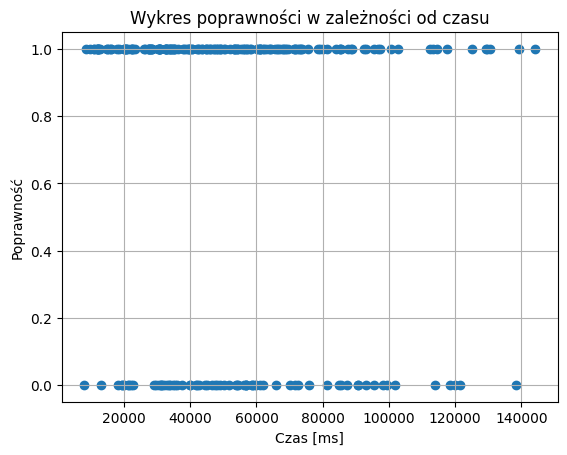

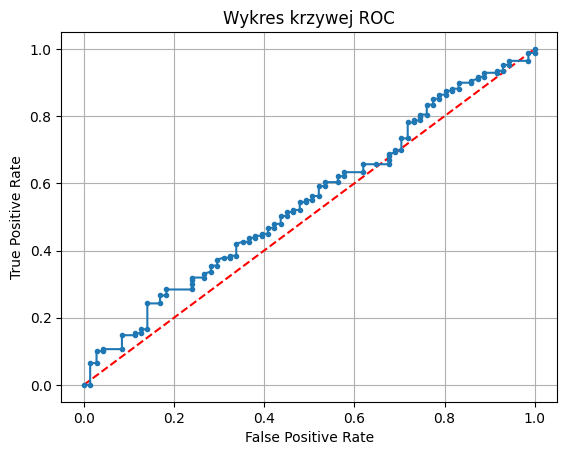

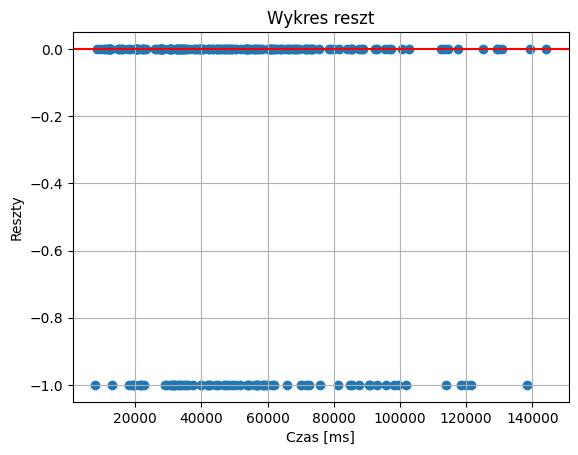

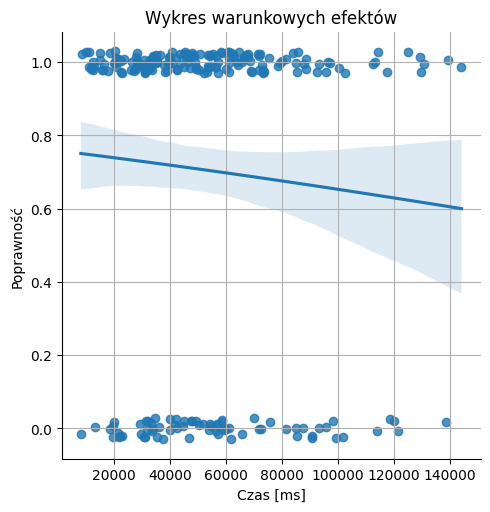

In [122]:
create_plots(df)

b) grafiki A

In [123]:
popr = []
for col in df_merge.columns.tolist():
    if col.endswith('a_corr'):
        popr.append(df_merge[col])

czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration') and col.endswith('a'):
        czas.append(df_merge[col])

df = prepate_set(czas, popr)
df.tail()

,poprawnosc,czas,intercept
115,0,42131,1.0
116,1,27199,1.0
117,0,19382,1.0
118,1,49298,1.0
119,1,67997,1.0


In [124]:
conduct_logistic_regression(df, H0, H1, ALPHA)

Optimization terminated successfully.
         Current function value: 0.601730
         Iterations 5
--------------------------------------------------------
p-value:  0.497459020898542
Brak podstaw do odrzucenia H0.
Nie ma istotnej statystycznie zależności między poprawnością odpowiedzi a czasem odpowiedzi.
--------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:             poprawnosc   No. Observations:                  120
Model:                          Logit   Df Residuals:                      118
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                0.003160
Time:                        19:21:22   Log-Likelihood:                -72.208
converged:                       True   LL-Null:                       -72.436
Covariance Type:            nonrobust   LLR p-value:                    0.4986


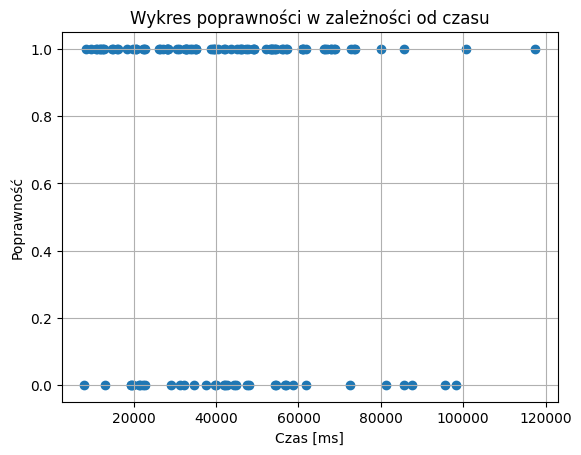

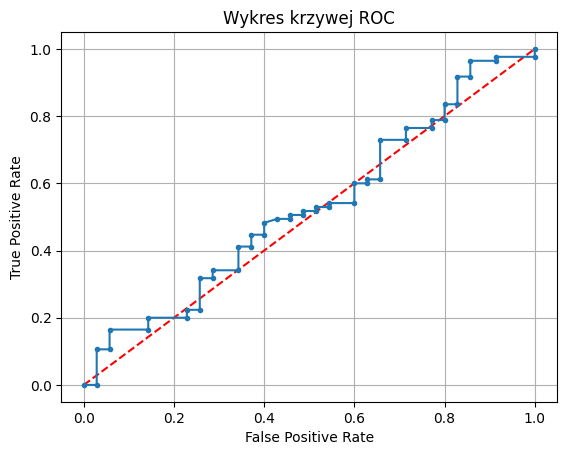

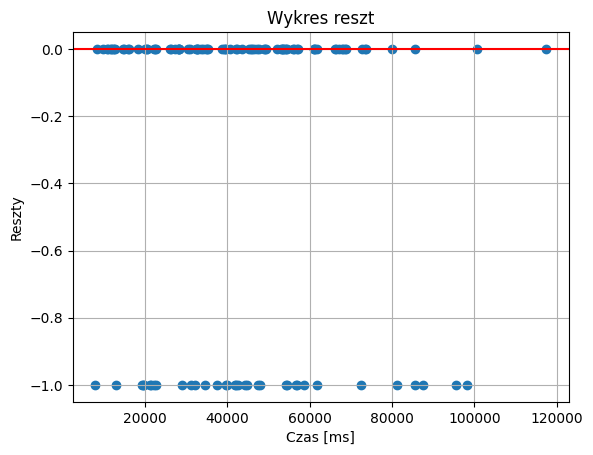

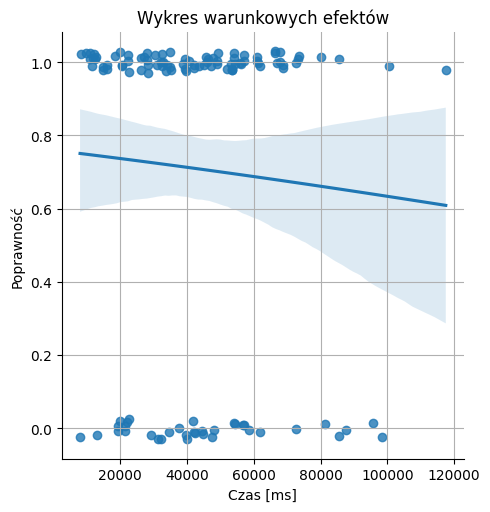

In [125]:
create_plots(df)

c) grafiki B

In [126]:
popr = []
for col in df_merge.columns.tolist():
    if col.endswith('b_corr'):
        popr.append(df_merge[col])

czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration') and col.endswith('b'):
        czas.append(df_merge[col])

df = prepate_set(czas, popr)
df.tail()

,poprawnosc,czas,intercept
115,1,55214,1.0
116,0,113828,1.0
117,0,93112,1.0
118,0,35898,1.0
119,0,119944,1.0


In [127]:
conduct_logistic_regression(df, H0, H1, ALPHA)

Optimization terminated successfully.
         Current function value: 0.607814
         Iterations 5
--------------------------------------------------------
p-value:  0.3909388844537306
Brak podstaw do odrzucenia H0.
Nie ma istotnej statystycznie zależności między poprawnością odpowiedzi a czasem odpowiedzi.
--------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:             poprawnosc   No. Observations:                  120
Model:                          Logit   Df Residuals:                      118
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                0.004993
Time:                        19:21:51   Log-Likelihood:                -72.938
converged:                       True   LL-Null:                       -73.304
Covariance Type:            nonrobust   LLR p-value:                    0.3922

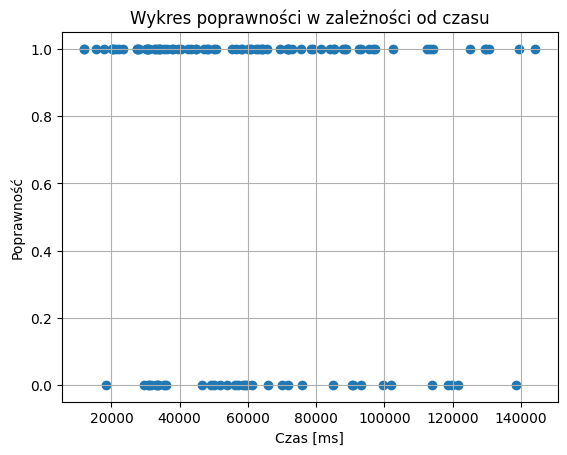

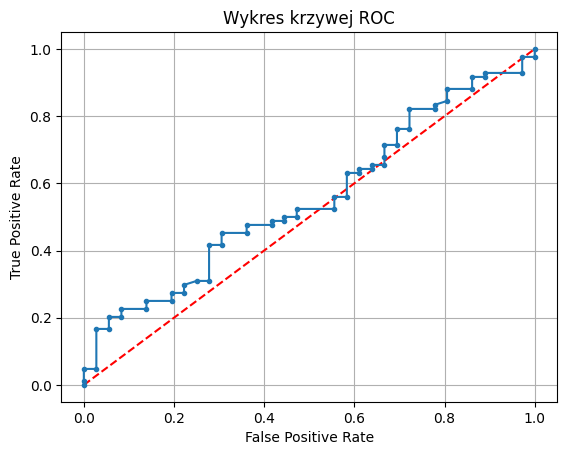

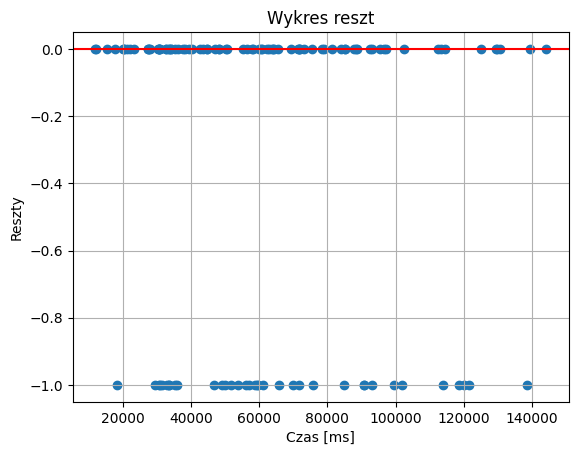

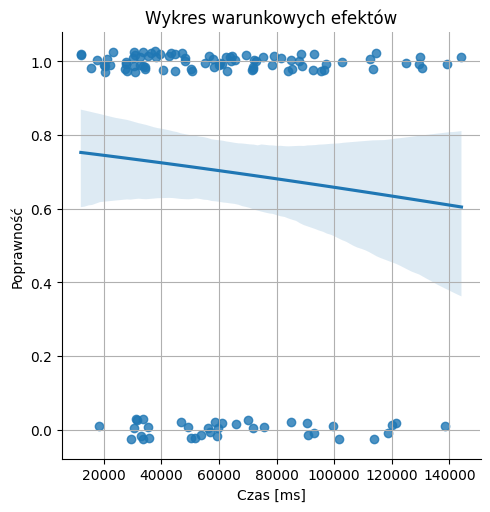

In [128]:
create_plots(df)

d) grafiki 1,2,3

-> 1

In [129]:
popr = []
for col in df_merge.columns.tolist():
    if col.startswith('1') and col.endswith('_corr'):
        popr.append(df_merge[col])

czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration_1'):
        czas.append(df_merge[col])

df = prepate_set(czas, popr)
df.tail()

,poprawnosc,czas,intercept
75,1,58347,1.0
76,1,64430,1.0
77,1,32732,1.0
78,1,47031,1.0
79,1,96628,1.0


In [130]:
conduct_logistic_regression(df, H0, H1, ALPHA)

Optimization terminated successfully.
         Current function value: 0.321967
         Iterations 7
--------------------------------------------------------
p-value:  0.495992729476448
Brak podstaw do odrzucenia H0.
Nie ma istotnej statystycznie zależności między poprawnością odpowiedzi a czasem odpowiedzi.
--------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:             poprawnosc   No. Observations:                   80
Model:                          Logit   Df Residuals:                       78
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                0.009586
Time:                        19:22:15   Log-Likelihood:                -25.757
converged:                       True   LL-Null:                       -26.007
Covariance Type:            nonrobust   LLR p-value:                    0.4801


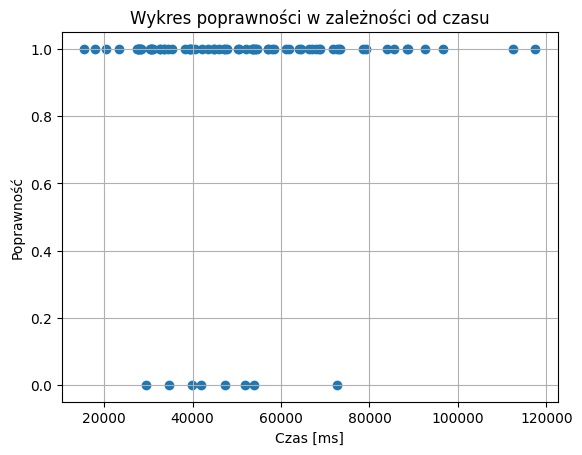

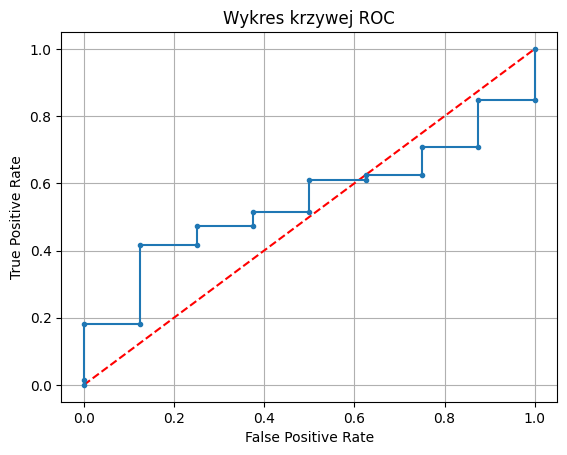

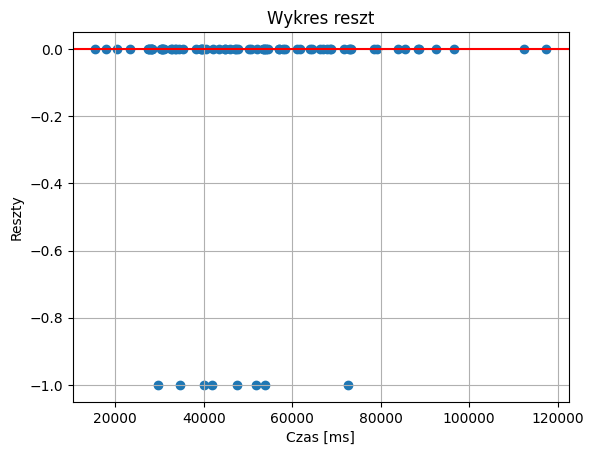

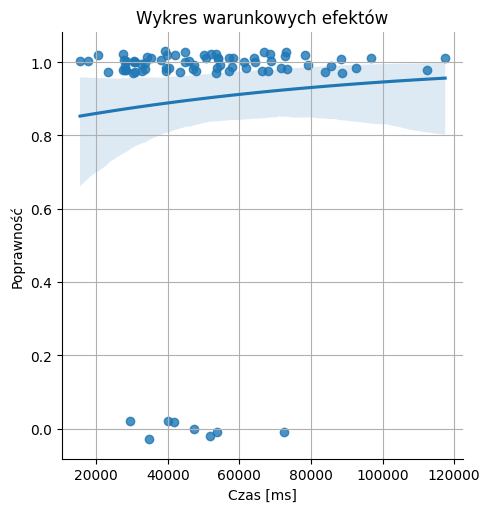

In [131]:
create_plots(df)

-> 2

In [132]:
popr = []
for col in df_merge.columns.tolist():
    if col.startswith('2') and col.endswith('_corr'):
        popr.append(df_merge[col])

czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration_2'):
        czas.append(df_merge[col])

df = prepate_set(czas, popr)
df.tail()

,poprawnosc,czas,intercept
75,1,34215,1.0
76,1,69413,1.0
77,1,60964,1.0
78,0,31582,1.0
79,1,113378,1.0


In [133]:
conduct_logistic_regression(df, H0, H1, ALPHA)

Optimization terminated successfully.
         Current function value: 0.529689
         Iterations 6
--------------------------------------------------------
p-value:  0.0018127792601140321
Istnieją podstawy do odrzucenia H0, przyjmujemy hipotezę H1:
Istnieje istotna statystycznie zależność między poprawnością odpowiedzi a czasem odpowiedzi.
--------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:             poprawnosc   No. Observations:                   80
Model:                          Logit   Df Residuals:                       78
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                  0.1170
Time:                        19:22:37   Log-Likelihood:                -42.375
converged:                       True   LL-Null:                       -47.992
Covariance Type:            nonrobust   LLR p

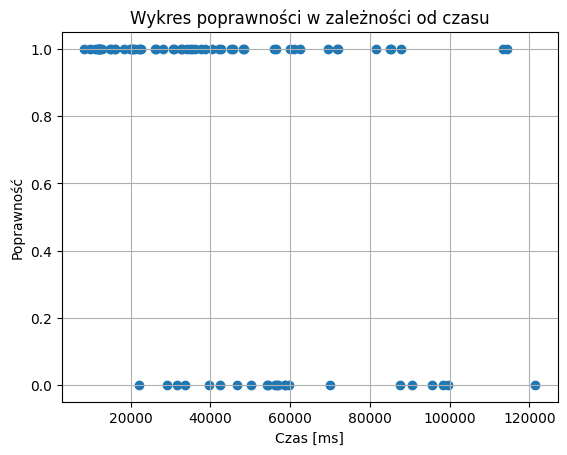

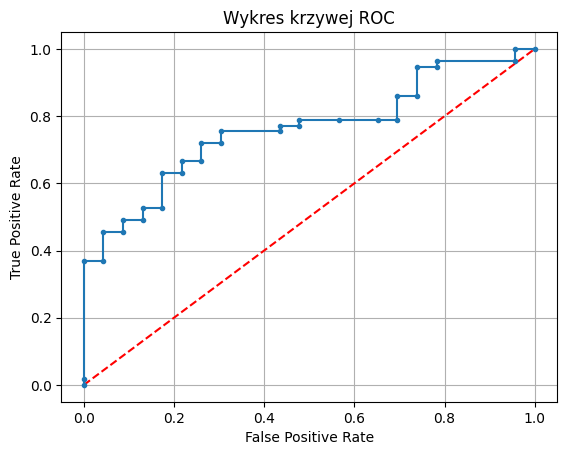

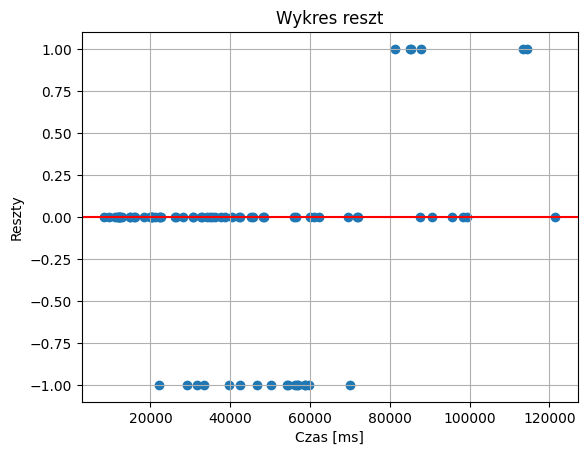

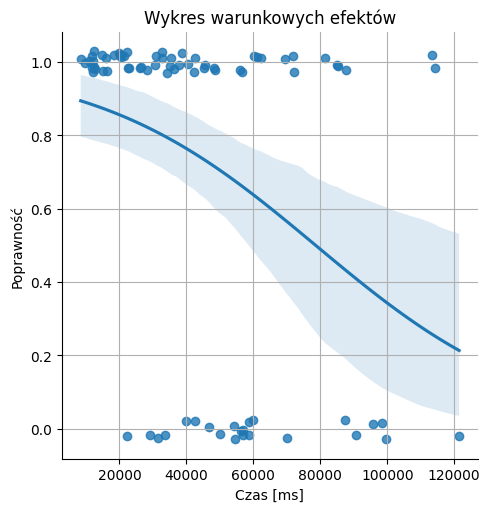

In [134]:
create_plots(df)

-> 3

In [135]:
popr = []
for col in df_merge.columns.tolist():
    if col.startswith('3') and col.endswith('_corr'):
        popr.append(df_merge[col])

czas = []
for col in df_merge.columns.tolist():
    if col.startswith('Duration_3'):
        czas.append(df_merge[col])

df = prepate_set(czas, popr)
df.tail()

,poprawnosc,czas,intercept
75,1,55214,1.0
76,0,113828,1.0
77,0,93112,1.0
78,0,35898,1.0
79,0,119944,1.0


In [136]:
conduct_logistic_regression(df, H0, H1, ALPHA)

Optimization terminated successfully.
         Current function value: 0.671444
         Iterations 4
--------------------------------------------------------
p-value:  0.07008699497487991
Brak podstaw do odrzucenia H0.
Nie ma istotnej statystycznie zależności między poprawnością odpowiedzi a czasem odpowiedzi.
--------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:             poprawnosc   No. Observations:                   80
Model:                          Logit   Df Residuals:                       78
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                 0.03131
Time:                        19:23:15   Log-Likelihood:                -53.716
converged:                       True   LL-Null:                       -55.452
Covariance Type:            nonrobust   LLR p-value:                   0.0624

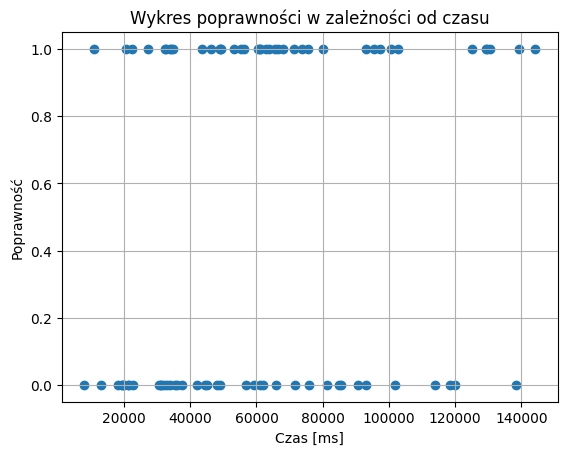

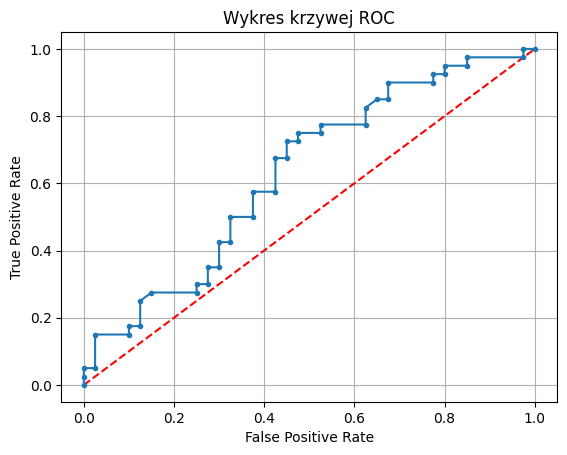

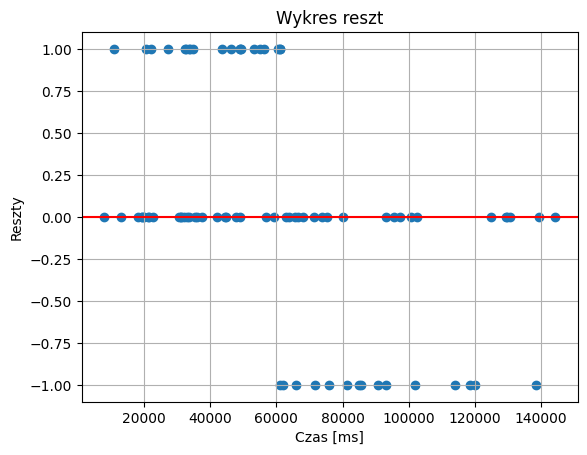

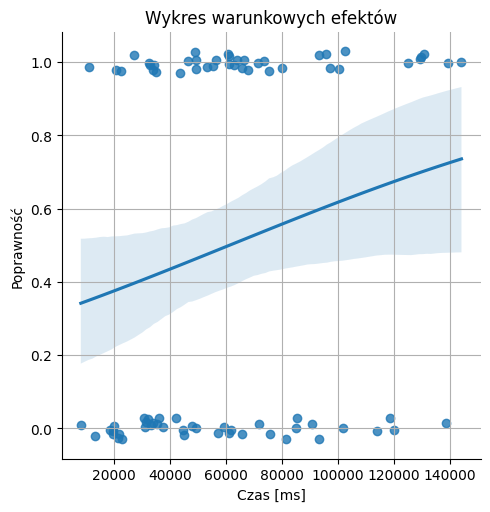

In [137]:
create_plots(df)

e) zadania 1a, 1b, 2a, 2b, 3a, 3b

In [138]:
df1a = pd.DataFrame({'czas': df_merge['Duration_1a'], 'poprawnosc': df_merge['1a_corr'], 'intercept': np.ones(40).astype(int)})
df2a = pd.DataFrame({'czas': df_merge['Duration_2a'], 'poprawnosc': df_merge['2a_corr'], 'intercept': np.ones(40).astype(int)})
df3a = pd.DataFrame({'czas': df_merge['Duration_3a'], 'poprawnosc': df_merge['3a_corr'], 'intercept': np.ones(40).astype(int)})

df1b = pd.DataFrame({'czas': df_merge['Duration_1b'], 'poprawnosc': df_merge['1b_corr'], 'intercept': np.ones(40).astype(int)})
df2b = pd.DataFrame({'czas': df_merge['Duration_2b'], 'poprawnosc': df_merge['2b_corr'], 'intercept': np.ones(40).astype(int)})
df3b = pd.DataFrame({'czas': df_merge['Duration_3b'], 'poprawnosc': df_merge['3b_corr'], 'intercept': np.ones(40).astype(int)})

dfs = [df1a, df1b, df2a, df2b, df3a, df3b]

In [139]:
for i, df in enumerate(dfs):
    print('-------------------------------------')
    print(f"{i+1}:")
    conduct_logistic_regression(df, H0, H1, ALPHA)

-------------------------------------
1:
Optimization terminated successfully.
         Current function value: 0.370280
         Iterations 6
--------------------------------------------------------
p-value:  0.4960341084430627
Brak podstaw do odrzucenia H0.
Nie ma istotnej statystycznie zależności między poprawnością odpowiedzi a czasem odpowiedzi.
--------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:             poprawnosc   No. Observations:                   40
Model:                          Logit   Df Residuals:                       38
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Oct 2023   Pseudo R-squ.:                 0.01723
Time:                        19:23:35   Log-Likelihood:                -14.811
converged:                       True   LL-Null:                       -15.071
Covariance Type:            nonrobust

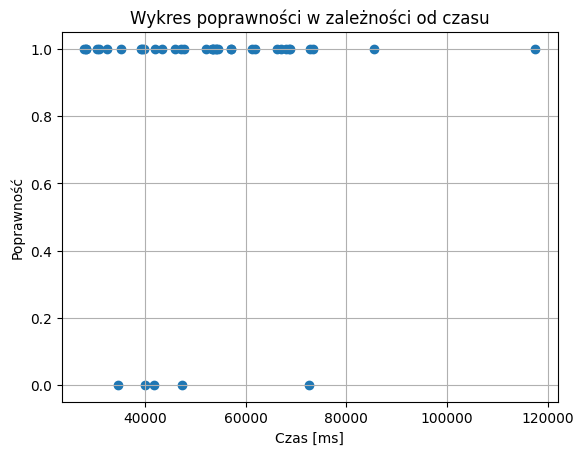

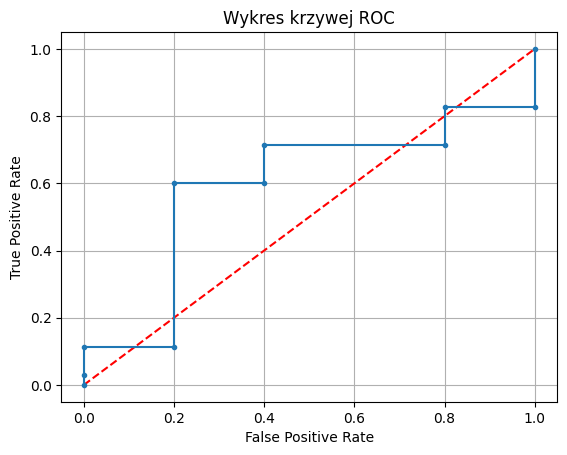

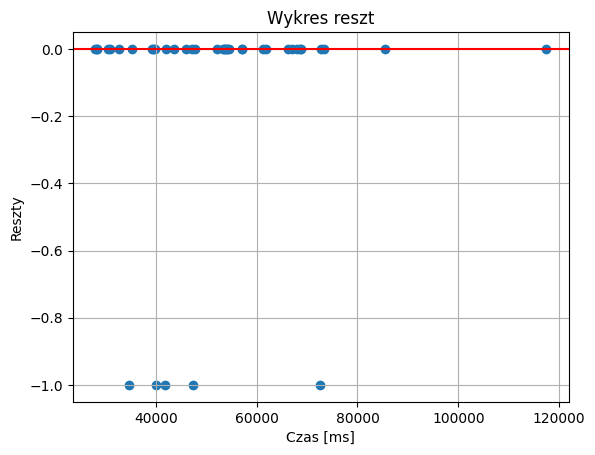

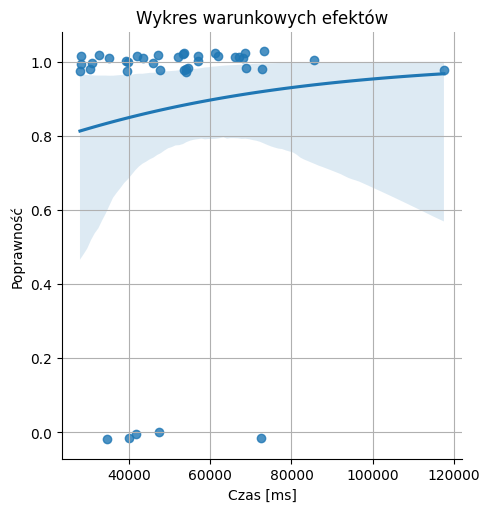

In [140]:
create_plots(df1a)

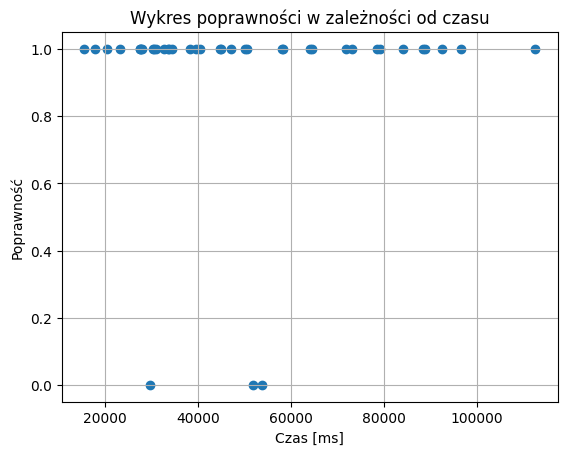

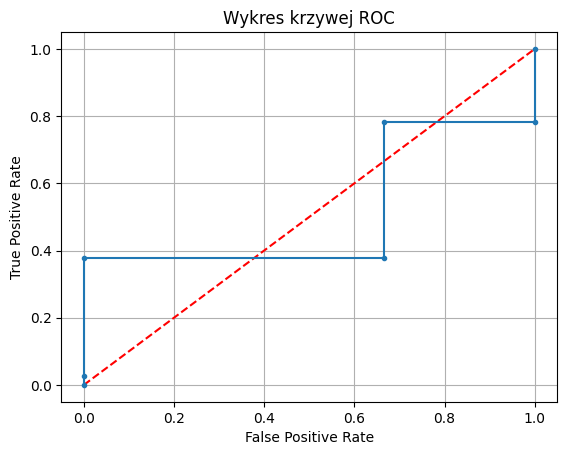

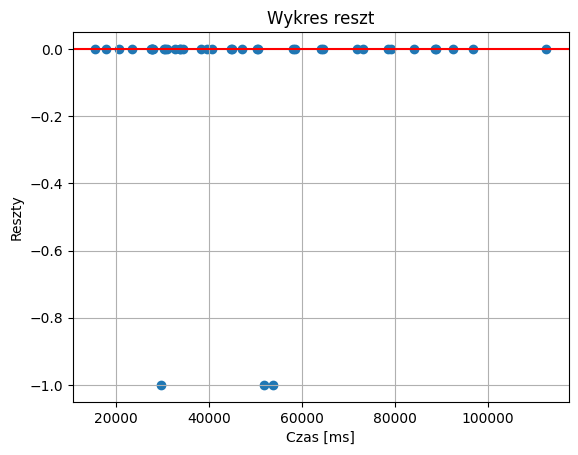

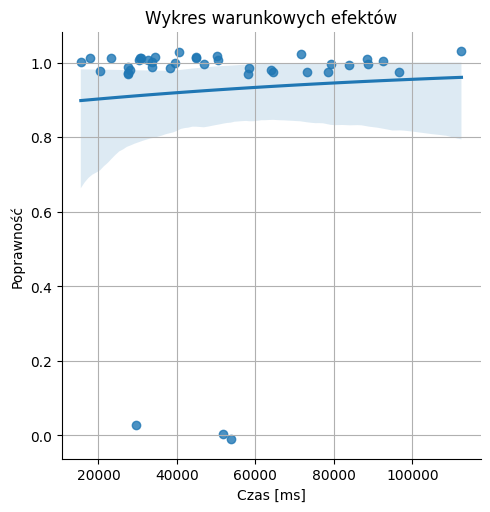

In [141]:
create_plots(df1b)

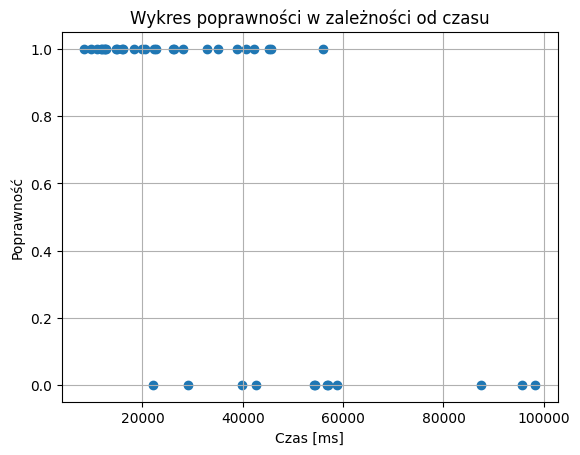

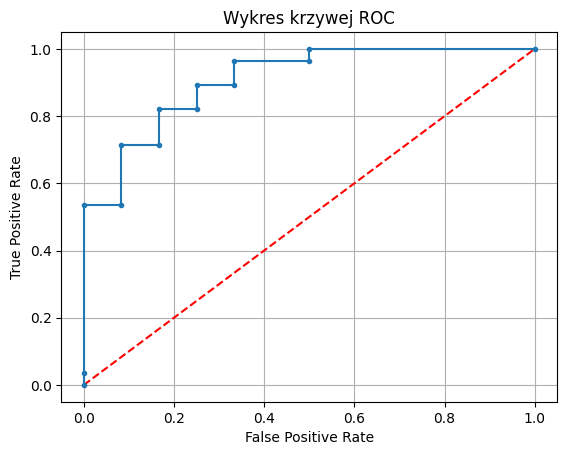

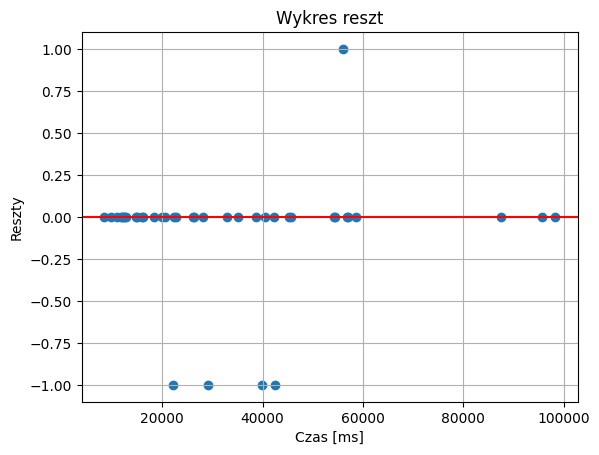

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


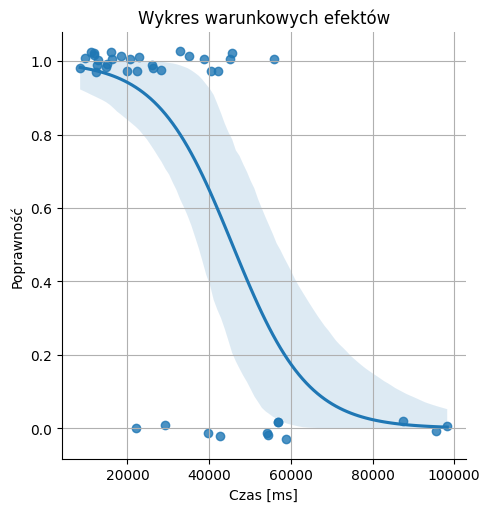

In [142]:
create_plots(df2a)

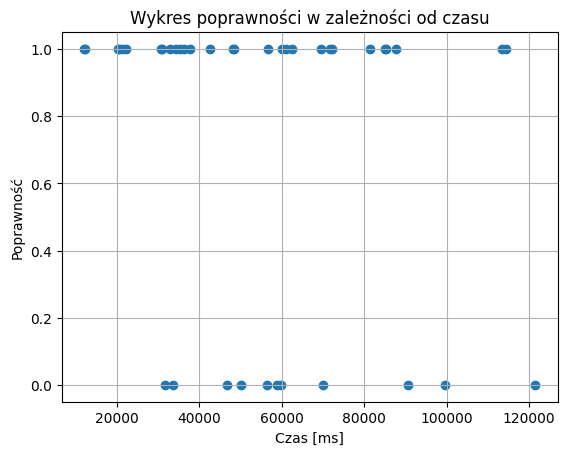

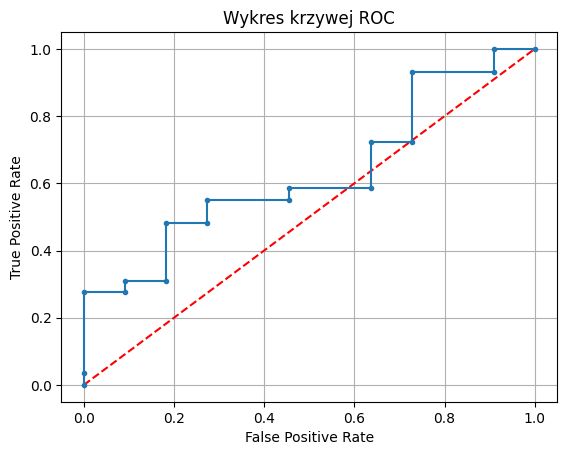

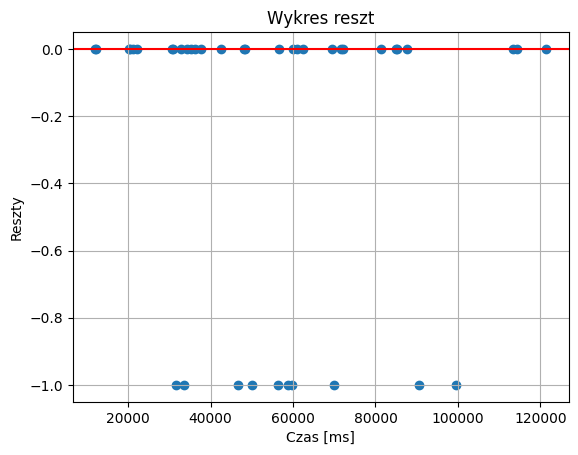

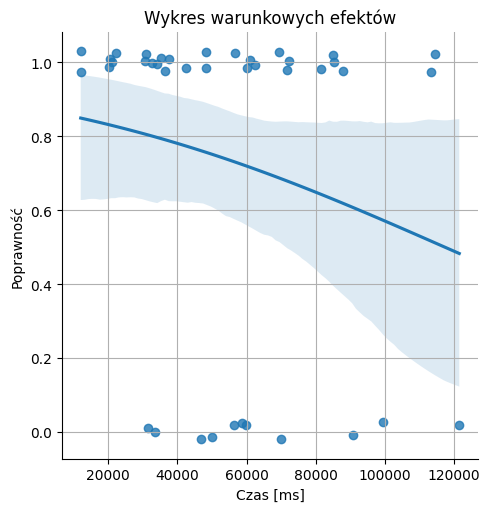

In [143]:
create_plots(df2b)

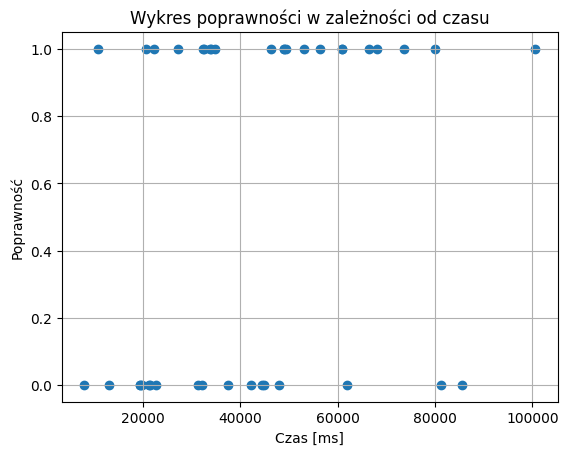

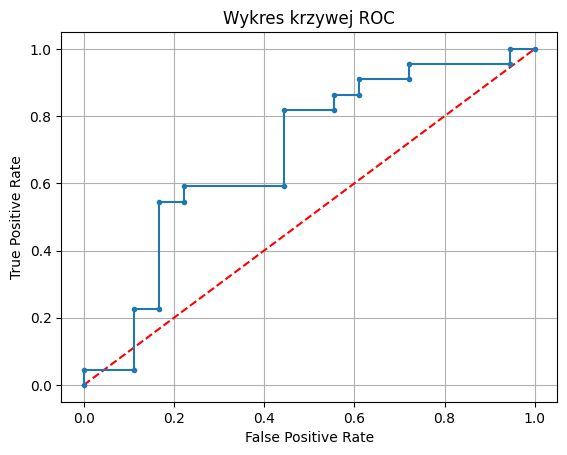

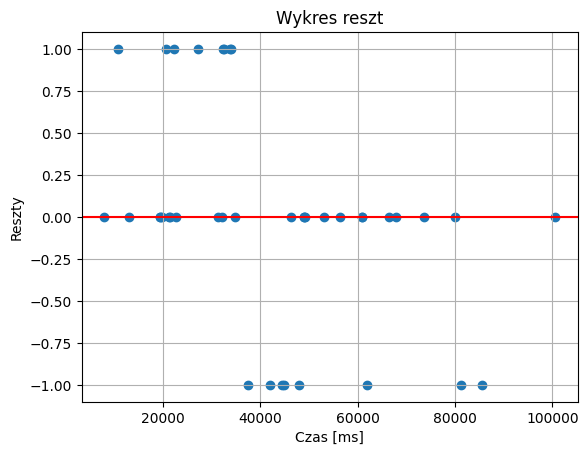

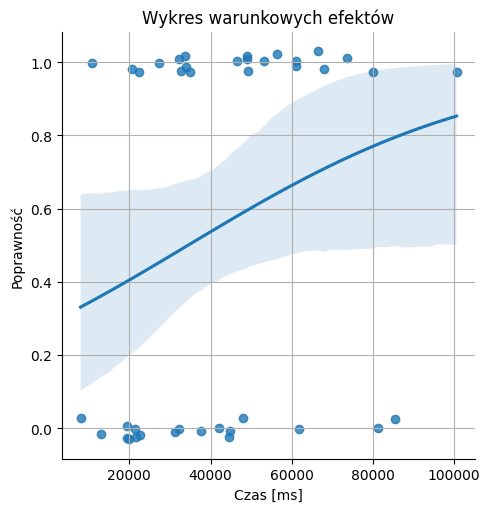

In [144]:
create_plots(df3a)

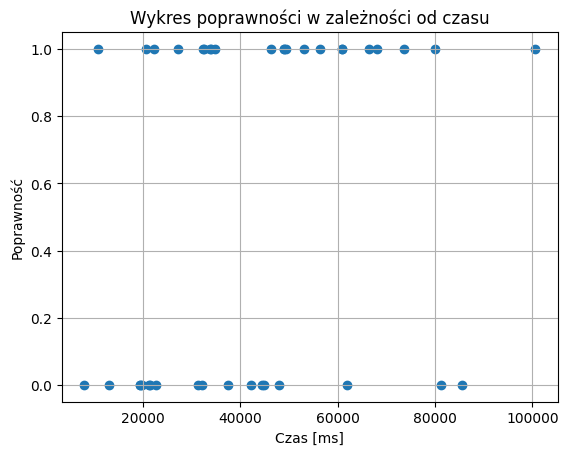

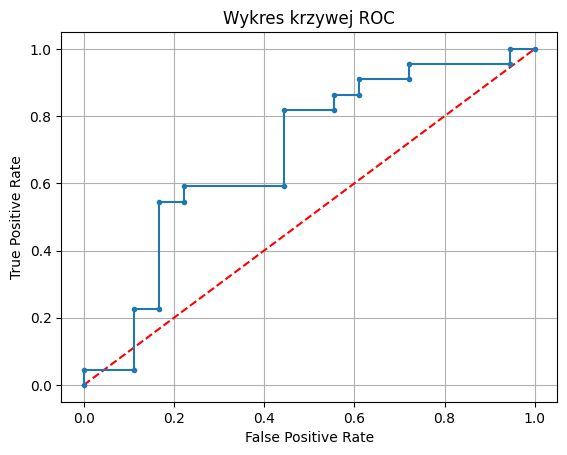

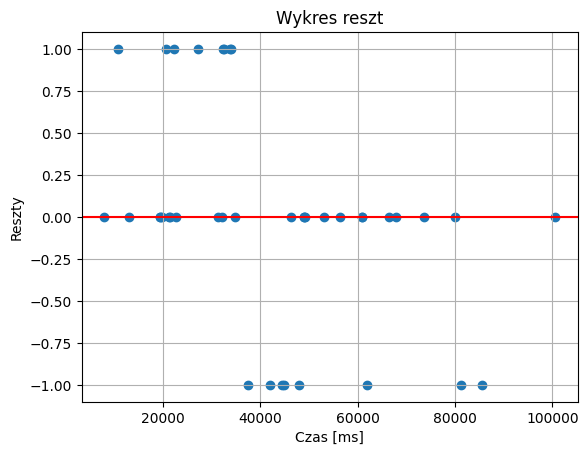

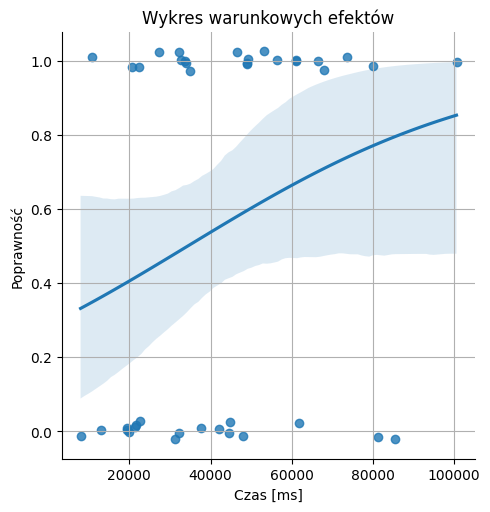

In [145]:
create_plots(df3a)

### Podsumowanie:
Istnieje istotna statystycznie zależność między poprawnością odpowiedzi a czasem odpowiedzi na poziomie istotności $\alpha=0.05$ dla:

- grafik 2 (wraz ze wzrostem czasu spadało prawodpodobieństwo udzielenia poprawnej odpowiedzi)
- grafiki 2a (wraz ze wzrostem czasu spadało prawodpodobieństwo udzielenia poprawnej odpowiedzi)
- grafiki 3b (wraz ze wzrostem czasu wzrastało prawodpodobieństwo udzielenia poprawnej odpowiedzi)

Potwierdzenie obserwacji: grafiki 2 były proste i niektórzy uczestnicy doszukiwali się 'haczyka', a grafiki 3 były trudne i im dłużej uczestnik zastanawiał się na tym pytaniem, tym była większa szansa, że poprawnie zrozumie polecenie